In [8]:
from __future__ import print_function
import pandas as pd
import numpy as np
from math import ceil
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch
import chartify
from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider
import ipywidgets as widgets
from gurobipy import *
import seaborn as sns
import numpy as np
from IPython.display import display
from bqplot import (
    OrdinalScale, LinearScale, Bars, Lines, Axis, Figure)

In [9]:
#set the number of hours to solve for
numhours = 1

#set the number of loading docks in the facility
numdoors = 100

#create ranges for hours and doors
hours = range(1,numhours+1)
doors = range(1,numdoors+1)

#set how many areas in the facility 
numareas = 4

#set goal load per associate for each area
areas, goal = multidict({
    1: 200,
    2: 200, 
    3: 150,
    4: 150
    })

#set the last door in each area
areas, lastDoorInArea = multidict({
    1: 25,
    2: 50,
    3: 75,
    4: 100
    }) 

#create the sets of doors that make up each area
areaDoors = {}
for area in areas:
    if area == 1:
        areaDoors[area] = range(1,lastDoorInArea[area]+1)
    else: 
        areaDoors[area] = range(lastDoorInArea[area-1]+1,lastDoorInArea[area]+1)

#set the limit of load size for any given associate
loadLimit = 300

#set the limit on the number of lines any given associate can be assigned
lineLimit = 8

In [10]:
#initialize sets for solutions, assignments and numassociates
solutions = {}
assignments = {}
numassociates = {}


#pull in volume matrix
volData = pd.read_csv('../Distribute/volData8.csv',header=None)
Vol = pd.DataFrame(volData,index=doors,columns=hours)
#create subsets of volume by area of the facility, such that you have a volume for any given area,door,hour combination
areaAreaDoorHour, Vol2 = multidict({'':0}) 
for a in areas:
    for i in areaDoors[a]:
        for h in hours:
            Vol2[a,i,h] = int(Vol.loc[i,h])
            
del Vol2['']

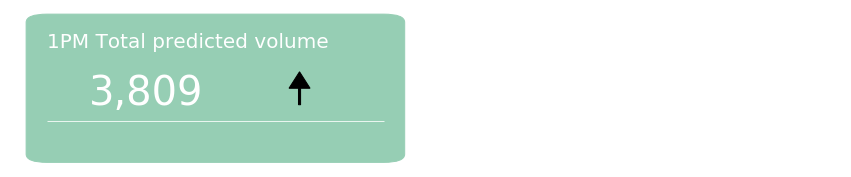

In [11]:
volData = pd.read_csv('../Distribute/volData8A.csv')

totalVol = volData.Hour8.sum()
average_price = totalVol / volData.Hour8.sum(); average_price


fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,3))

p_fancy = FancyBboxPatch(xy= (0.1, 0.1), width= 0.8,height= 0.8, boxstyle="round,pad=0.05", fc= "#96CEB4", ec= "#96CEB4")
axes[0].add_patch(p_fancy)
axes[0].text(0.2, 0.4,"{:,}".format(totalVol),size=40, color = "#ffffff")
axes[0].text(0.1, 0.75, "1PM Total predicted volume",size=20, color = "#ffffff")
axes[0].text(0.1, 0.15, "",size=12, color = "#ffffff")
axes[0].arrow(0.7, 0.4, 0, 0.1, head_width=0.05, head_length=0.1, width= 0.005, fc='k', ec='k')
axes[0].hlines(y = 0.3, xmin=0.1, xmax=0.9, linewidth=0.8, color = "#ffffff")

'''
p_fancy = FancyBboxPatch(xy= (0.1, 0.1), width= 0.8,height= 0.8, boxstyle="round,pad=0.05", fc= "#FF6F69", ec= "#FF6F69")
axes[1].add_patch(p_fancy)
axes[1].text(0.2, 0.4,format(round(average_price,1)),size=40, color = "#ffffff")
axes[1].text(0.1, 0.75, "average price",size=20, color = "#ffffff")
axes[1].text(0.1, 0.15, "2018-12-24",size=12, color = "#ffffff")
axes[1].arrow(0.7, 0.6, 0, -0.1, head_width=0.05, head_length=0.1, width= 0.005, fc='k', ec='k')
axes[1].hlines(y = 0.3, xmin=0.1, xmax=0.9, linewidth=0.8, color = "#ffffff")
   '''
for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    for pos in ['top','right','left','bottom']:
        ax.spines[pos].set_visible(False)

plt.subplots_adjust(wspace =  0.01)
plt.show()

In [6]:
volData = pd.read_csv('../Distribute/volData8A.csv')
areaVol = pd.DataFrame(volData.groupby('Area').Hour8.sum()).reset_index()
ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("1PM Predicted Demand by Area")
ch.plot.text(
        data_frame=areaVol,
        categorical_columns='Area',
        numeric_column='Hour8',
        text_column='Hour8')
ch.style.color_palette.reset_palette_order()
ch.plot.bar(
    data_frame=areaVol,
    categorical_columns='Area',
    numeric_column='Hour8',
    categorical_order_by=[4,3,2,1],
    categorical_order_ascending=True,
    color_column='Area'
)
ch.show('html')

In [7]:
volData = pd.read_csv('../Distribute/volData8A.csv')
ch = chartify.Chart(blank_labels=True, x_axis_type='categorical')
ch.set_title("4PM Predicted Demand by Door")
ch.plot.bar(
    data_frame=volData,
    categorical_columns='Door',
    numeric_column='Hour8',
    categorical_order_by='labels',
    categorical_order_ascending=True,
    color_column='Area',
    color_order=[1,2,3,4])
ch.axes.hide_xaxis()
ch.show('html')

In [8]:
used = {}
volNotLoaded = 0
interact_calc=interact.options(manual=True, manual_name="Run Allocation")

@interact_calc()
def solve():
    m = Model('DynamicResourceAllocation')
    for hour in hours:
        associateID = 1
        for area in [1,2,3,4]: 
            
            #print('area:',area)
            #determine the number of associates required by volume for the hour
            numassociates[area,hour] = ceil(sum(Vol2[area,door,hour] for door in areaDoors[area] if Vol2[area,door,hour] > 0)/goal[area])
            #set the range of associates
            associates = range(1,numassociates[area,hour]+1)

            ''' ----- DECISION VARIABLES -----  '''

            #Assignment of doors to associates
            X = m.addVars(areaDoors[area],associates,vtype=GRB.BINARY,name='X')
            #Whether associate is used or not
            Z = m.addVars(associates,vtype=GRB.BINARY,name='Z')
            #Deviation under goal
            alpha = m.addVars(associates,lb=0.0, vtype=GRB.CONTINUOUS,name='alpha')

            # ----- OBJECTIVE FUNCTION ----- #

            m.setObjective(quicksum(alpha[j] for j in associates),GRB.MINIMIZE)

            ''' ----- CONSTRAINTS ----- '''

            '''For any associate in the set of associates that are calculated as needed in that area and hour, 
            the sum of volume going to the doors that associate is assigned must be greater than or equal to 
            the goal, minus the underachievement.'''
            m.addConstrs((sum(Vol2[area,i, hour] * X[i,j] for i in areaDoors[area] if Vol2[area, i, hour] > 0) 
                >=  Z[j]*goal[area] - alpha[j] for j in associates),"devFromGoal")

            '''Ensure that associates are only assigned to doors that are adjacent to each other. 
            If a door has a volume of zero, it will skip the consideration of assigning an associate 
            to that door, and thus the next adjacent door can be assigned.'''
            m.addConstrs((X[i2,j] >= X[i1,j] + X[i3,j] - 1 
                for j in associates for i1 in areaDoors[area] if Vol2[area,i1,hour]>0 
                for i2 in areaDoors[area] if Vol2[area,i2,hour]>0 for i3 in areaDoors[area] if Vol2[area,i3,hour]>0 
                if i1<i2<i3),"doorAdjacency")

            '''Ensure that a door is assigned to one associate and only one.'''
            m.addConstrs((sum(X[i,j] for j in associates) == 1 for i in areaDoors[area] if Vol2[area, i, hour] > 0),"assignOnly1")

            '''Ensure that if a door has no volume in a given hour, it must not be assigned.'''
            m.addConstrs((sum(X[i,j] for j in associates) == 0 for i in areaDoors[area] if Vol2[area, i, hour] == 0),"doNotAssignZeroVolDoor")

            '''Binary switching constraints. If a door is assigned an associate, that associate must be considered as used.'''
            m.addConstrs((X[i,j] <= Z[j] for j in associates for i in areaDoors[area] if Vol2[area, i, hour] > 0),"usedBinarySwitch")

            '''If an associate is to be used, they must be assigned to at least one door.'''
            m.addConstrs((quicksum(X[i,j] for i in areaDoors[area]) >= Z[j] for j in associates),"assignedBinarySwitch")

            '''Ensure that the deviation for an associate does not exceed the goal for that associate (don't completely understand this) '''
            m.addConstrs((alpha[j] <= goal[area]*Z[j] for j in associates),"IDK")

            '''The model has to use the number of associates that are calculated as needed in the area and hour,
            minus one associate if it can find a way to feasibly do so.'''
            m.addConstr((quicksum(Z[j] for j in associates) >= numassociates[area,hour]-1),"minusOneIfPossible")

            '''Ensure that the volume assigned to an associate across doors to not exceed a certain number of cartons.'''
            m.addConstrs((quicksum(Vol2[area,i,hour] * X[i,j] for i in areaDoors[area]) <= loadLimit for j in associates),"loadLimit")

            '''Ensure that the number of doors an associate is assigned never exceeds a certain number.'''
            m.addConstrs((quicksum(X[i,j] for i in areaDoors[area]) <= lineLimit for j in associates),"lineLimit")

            ''' ----- BEGIN RUN ----- '''
            #print('Beginning optimization')
            #allow optimization to run in the background without displaying all the output; solve
            m.setParam( 'OutputFlag', False )
            m.optimize()
            
            ''' ----- POST-SOLUTION PROCESSING ----- '''

            #obj = m.getObjective()
            #solutions[area,hour] = obj.getValue()

            #calculate the load per used associate and whether associate was used
            load = {}
            
            totalUsed = 0
            for j in associates: 
                load[area,hour,j] = sum(Vol2[area,i,hour]*X[i,j].x for i in areaDoors[area] if Vol2[area,i,hour]>0)
                if load[area,hour,j] > 0:
                    used[area,hour,j] = 1
                else: 
                    used[area,hour,j] = 0
                totalUsed += used[area,hour,j]

            #create a dataFrame for the hour, which will contain the associate to door assignments
            assignments[area,hour] = pd.DataFrame(data=None,index=areaDoors[area],columns=associates)
            
            for j in associates:
                if Z[j].x==1:
                    for i in areaDoors[area]:
                        if X[i,j].x == 1:
                            assignments[area,hour].loc[i,j] = associateID
                        else:
                            assignments[area,hour].loc[i,j] = 0
                    associateID += 1
            #calculate the area productivity
            productivity = {}

        assignmentsFull = pd.DataFrame()
        for a in assignments:
            assignmentsFull = assignmentsFull.append(assignments[a])
            numAssociates = len(assignmentsFull.columns)
        assignmentsFull = assignmentsFull.loc[:, 1:numAssociates].replace(1, pd.Series(assignmentsFull.columns, assignmentsFull.columns))
        assignmentsFull['Assignment'] = assignmentsFull.max(axis=1)
        assignmentsFull['Hour'] = hour
        assignmentsFull = assignmentsFull.reset_index().rename({'index':'Door'},axis=1)
        assignmentsFull = assignmentsFull[['Hour','Door','Assignment']]
        assignmentsFull.to_csv('Hour{}.csv'.format(hour),index=False)
    

interactive(children=(Button(description='Run Allocation', style=ButtonStyle()), Output()), _dom_classes=('wid…

In [9]:
#making the chart for each hour
charts = {}
hours = range(1,8)
def makeChart(hour):
    #resultsData = pd.read_csv('Hour7.csv')
    #resultsData = resultsData[resultsData.Hour==hour]
    #ax = sns.barplot(x="Door", y="Volume",hue='Assignment', data=resultsData)
    
    ch = chartify.Chart(blank_labels=True, x_axis_type='categorical')
    ch.set_title("Associate to Door Assignment")
    ch.plot.bar(
        data_frame=resultsData,
        categorical_columns='Door',
        numeric_column='Volume',
        categorical_order_by='labels',
        categorical_order_ascending=True,
        color_column='Assignment')
        #color_order=[i for i in range(1,int(resultsData.Assignment.max())+1)])
    ch.axes.hide_xaxis()
    ch.set_legend_location(None)
    ch.style.color_palette.reset_palette_order()
    return ax


'for hour in hours:\n    charts[hour] = makeChart(hour)'

In [42]:
#@showDoorLevelResults()
def showDoorLevelResults(hour):
    resultsData = pd.read_csv('Hour7.csv')
    resultsData = resultsData[resultsData.Hour==hour]
    ch = chartify.Chart(blank_labels=True, x_axis_type='categorical')
    ch.set_title("Associate to Door Assignment")
    ch.plot.bar(
        data_frame=resultsData,
        categorical_columns='Door',
        numeric_column='Volume',
        categorical_order_by='labels',
        categorical_order_ascending=True,
        color_column='Assignment')
        #color_order=[i for i in range(1,int(resultsData.Assignment.max())+1)])
    ch.axes.hide_xaxis()
    ch.set_legend_location(None)
    ch.style.color_palette.reset_palette_order()
    return ch.show('html')
testFig = interact(showDoorLevelResults, hour=widgets.IntSlider(min=1,max=7,step=1,value=1));

interactive(children=(IntSlider(value=1, description='hour', max=7, min=1), Output()), _dom_classes=('widget-i…

In [51]:
showDoorLevelResults(1)

In [12]:
#: 10 colors that work well together as data category colors
CATEGORY10 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

#: 20 colors that work well together as data category colors
CATEGORY20 = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
              '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
              '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
              '#17becf', '#9edae5']

#: 20 colors that work well together as data category colors
CATEGORY20b = ['#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939',
               '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39',
               '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b',
               '#e7969c', '#7b4173', '#a55194', '#ce6dbd', '#de9ed6']

#: 20 colors that work well together as data category colors
CATEGORY20c = ['#3182bd', '#6baed6', '#9ecae1', '#c6dbef', '#e6550d',
               '#fd8d3c', '#fdae6b', '#fdd0a2', '#31a354', '#74c476',
               '#a1d99b', '#c7e9c0', '#756bb1', '#9e9ac8', '#bcbddc',
               '#dadaeb', '#636363', '#969696', '#bdbdbd', '#d9d9d9']

<i>content-main</i>

In [54]:
#@showDoorLevelResults()
def showDoorLevelResults(hour):
    resultsData = pd.read_csv('Hour7.csv')
    resultsData = resultsData[resultsData.Hour==hour]
    bar = Bars(x=resultsData.Door, y=resultsData.Volume, scales={'x': OrdinalScale(), 'y':
    LinearScale()}, type='grouped',color_mode='auto',colors=CATEGORY20c)

    ax_x = Axis(scale=OrdinalScale(), grid_lines='solid',tick_values=None,num_ticks=0)

    ax_y = Axis(scale=LinearScale(), orientation='vertical', tick_format='0f',grid_lines='solid')

    fig = Figure(marks=[bar], axes=[ax_x, ax_y], title='TEST')
    return fig
interact(showDoorLevelResults, hour=widgets.IntSlider(min=1,max=7,step=1,value=1));

interactive(children=(IntSlider(value=1, description='hour', max=7, min=1), Output()), _dom_classes=('widget-i…

# Set up voila vuetify layout
The voila vuetify template does not render output from the notebook, it only shows widget with the mount_id metadata.

In [55]:
sliderHist2 = vue.Slider(_metadata={'mount_id': 'histogram_bins2'}, thumb_label='always', class_='px-4', v_model=5)

In [56]:
vue.Tabs(_metadata={'mount_id': 'content-main'}, children=[
    vue.Tab(children=['Tab1']),
    vue.Tab(children=['Tab2']),
    vue.TabItem(children=[
        vue.Layout(row=True, wrap=True, align_center=True, children=[
            vue.Flex(xs12=True, lg6=True, xl4=True, children=[
                showDoorLevelResults(1), sliderHist2
            ]),
            vue.Flex(xs12=True, lg6=True, xl4=True, children=[
                showDoorLevelResults(1), sliderHist2
            ]),
            vue.Flex(xs12=True, xl4=True, children=[
                showDoorLevelResults(1)
            ]),
        ])
    ]),
    vue.TabItem(children=[
        vue.Container(children=['Lorum ipsum'])
    ])
])

Tabs(children=[Tab(children=['Tab1']), Tab(children=['Tab2']), TabItem(children=[Layout(align_center=True, chi…